# TODOs:
1. analyze outliars and decide to keep/transform/remove
2. analyze nans (now are removed) and decide to transform/remove
3. add detailed EDA of interesting aspects
4. use names (cluster and classify using unsuervised methods) as features
5. try using PassengerId group number as int
6. add EDA and classification pipeline (preprocess + normalization + classification) to test data and create submission file
7. add kaggle submission and evaluation code

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Exploring train data

1. **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
3. **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. **Destination** - The planet the passenger will be debarking to.
6. **Age** - The age of the passenger.
7. **VIP** - Whether the passenger has paid for special VIP service during the voyage.
8. **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. **Name** - The first and last names of the passenger.

10. **Transported** - Whether the passenger was transported to another dimension. **This is the target to predict.**

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [3]:
train_df.shape

(8693, 14)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# as long as Name is unused
train_df['Name'] = train_df['Name'].fillna('John Doe')

In [6]:
train_df = train_df.dropna()
train_df = train_df.reset_index(drop=True)
train_df.shape

(6764, 14)

In [7]:
train_target_sr = train_df.Transported
train_df = train_df.drop('Transported', axis=1)
train_target_sr.value_counts()

True     3401
False    3363
Name: Transported, dtype: int64

## Feature engineering

In [8]:
# TODO: consider making detailed EDA for correlations between deck and socieconomic status (VIP, billing etc)
train_df[['CabinDeck', 'CabinNum', 'CabinSide']] = train_df['Cabin'].str.split(pat='/', n=2, expand=True)
train_df['CabinNum'] = train_df['CabinNum'].astype(float)
train_df = train_df.drop(['Cabin'], axis=1)

In [9]:
# TODO: consider doing this before dropna.
train_df[['PassengerId_g', 'PassengerId_p']] = train_df['PassengerId'].str.split(pat='_', n=1, expand=True)
train_df['PassengerId_p'] = train_df['PassengerId_p'].astype(float)
train_df['GroupSize'] = train_df.apply(lambda row: train_df[train_df['PassengerId_g'] == row.PassengerId_g].PassengerId_p.max(), axis=1)
train_df = train_df.drop(['PassengerId', 'PassengerId_g', 'PassengerId_p'], axis=1)

In [10]:
train_df = train_df.replace({'TRAPPIST-1e': 'Trappist', '55 Cancri e': 'Cancri', 'PSO J318.5-22': 'Pso'})

In [11]:
train_df[['NameFirst', 'NameLast']] = train_df['Name'].str.split(pat=' ', n=2, expand=True)
train_df = train_df.drop(['Name'], axis=1)

In [12]:
train_df = pd.get_dummies(train_df, columns=['HomePlanet', 'CabinDeck', 'CabinSide', 'VIP', 'CryoSleep', 'Destination'], drop_first=True)
train_df['Transported'] = train_target_sr
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   6764 non-null   float64
 1   RoomService           6764 non-null   float64
 2   FoodCourt             6764 non-null   float64
 3   ShoppingMall          6764 non-null   float64
 4   Spa                   6764 non-null   float64
 5   VRDeck                6764 non-null   float64
 6   CabinNum              6764 non-null   float64
 7   GroupSize             6764 non-null   float64
 8   NameFirst             6764 non-null   object 
 9   NameLast              6764 non-null   object 
 10  HomePlanet_Europa     6764 non-null   uint8  
 11  HomePlanet_Mars       6764 non-null   uint8  
 12  CabinDeck_B           6764 non-null   uint8  
 13  CabinDeck_C           6764 non-null   uint8  
 14  CabinDeck_D           6764 non-null   uint8  
 15  CabinDeck_E          

In [13]:
train_df.describe()

Age  RoomService     FoodCourt  ShoppingMall           Spa  \
count  6764.000000  6764.000000   6764.000000   6764.000000   6764.000000   
mean     28.897398   224.415582    479.736251    180.495713    313.856298   
std      14.529563   648.056361   1676.922138    638.032157   1138.989471   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%      19.000000     0.000000      0.000000      0.000000      0.000000   
50%      27.000000     0.000000      0.000000      0.000000      0.000000   
75%      38.000000    51.000000     82.000000     30.250000     66.250000   
max      79.000000  9920.000000  29813.000000  23492.000000  22408.000000   

             VRDeck     CabinNum    GroupSize  HomePlanet_Europa  \
count   6764.000000  6764.000000  6764.000000        6764.000000   
mean     304.565937   598.266854     1.959787           0.252957   
std     1126.895655   512.567208     1.538556           0.434739   
min        0.000000     0.000000     1.000000           0.000000   
25%        0.000000   165.750000     1.000000           0.000000   
50%        0.000000   423.500000     1.000000           0.000000   
75%       52.000000   994.000000     2.000000           1.000000   
max    20336.000000  1894.000000     8.000000           1.000000   

       HomePlanet_Mars  ...  CabinDeck_D  CabinDeck_E  CabinDeck_F  \
count      6764.000000  ...  6764.000000  6764.000000  6764.000000   
mean          0.206535  ...     0.056328     0.103489     0.326434   
std           0.404848  ...     0.230570     0.304619     0.468943   
min           0.000000  ...     0.000000     0.000000     0.000000   
25%           0.000000  ...     0.000000     0.000000     0.000000   
50%           0.000000  ...     0.000000     0.000000     0.000000   
75%           0.000000  ...     0.000000     0.000000     1.000000   
max           1.000000  ...     1.000000     1.000000     1.000000   

       CabinDeck_G  CabinDeck_T  CabinSide_S     VIP_True  CryoSleep_True  \
count  6764.000000  6764.000000  6764.000000  6764.000000     6764.000000   
mean      0.298492     0.000444     0.506357     0.024246        0.351863   
std       0.457630     0.021057     0.499997     0.153823        0.477587   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.000000     0.000000     0.000000     0.000000        0.000000   
50%       0.000000     0.000000     1.000000     0.000000        0.000000   
75%       1.000000     0.000000     1.000000     0.000000        1.000000   
max       1.000000     1.000000     1.000000     1.000000        1.000000   

       Destination_Pso  Destination_Trappist  
count      6764.000000           6764.000000  
mean          0.094619              0.692194  
std           0.292709              0.461620  
min           0.000000              0.000000  
25%           0.000000              0.000000  
50%           0.000000              1.000000  
75%           0.000000              1.000000  
max           1.000000              1.000000  

[8 rows x 22 columns]

CPU times: total: 2min 33s
Wall time: 2min 33s


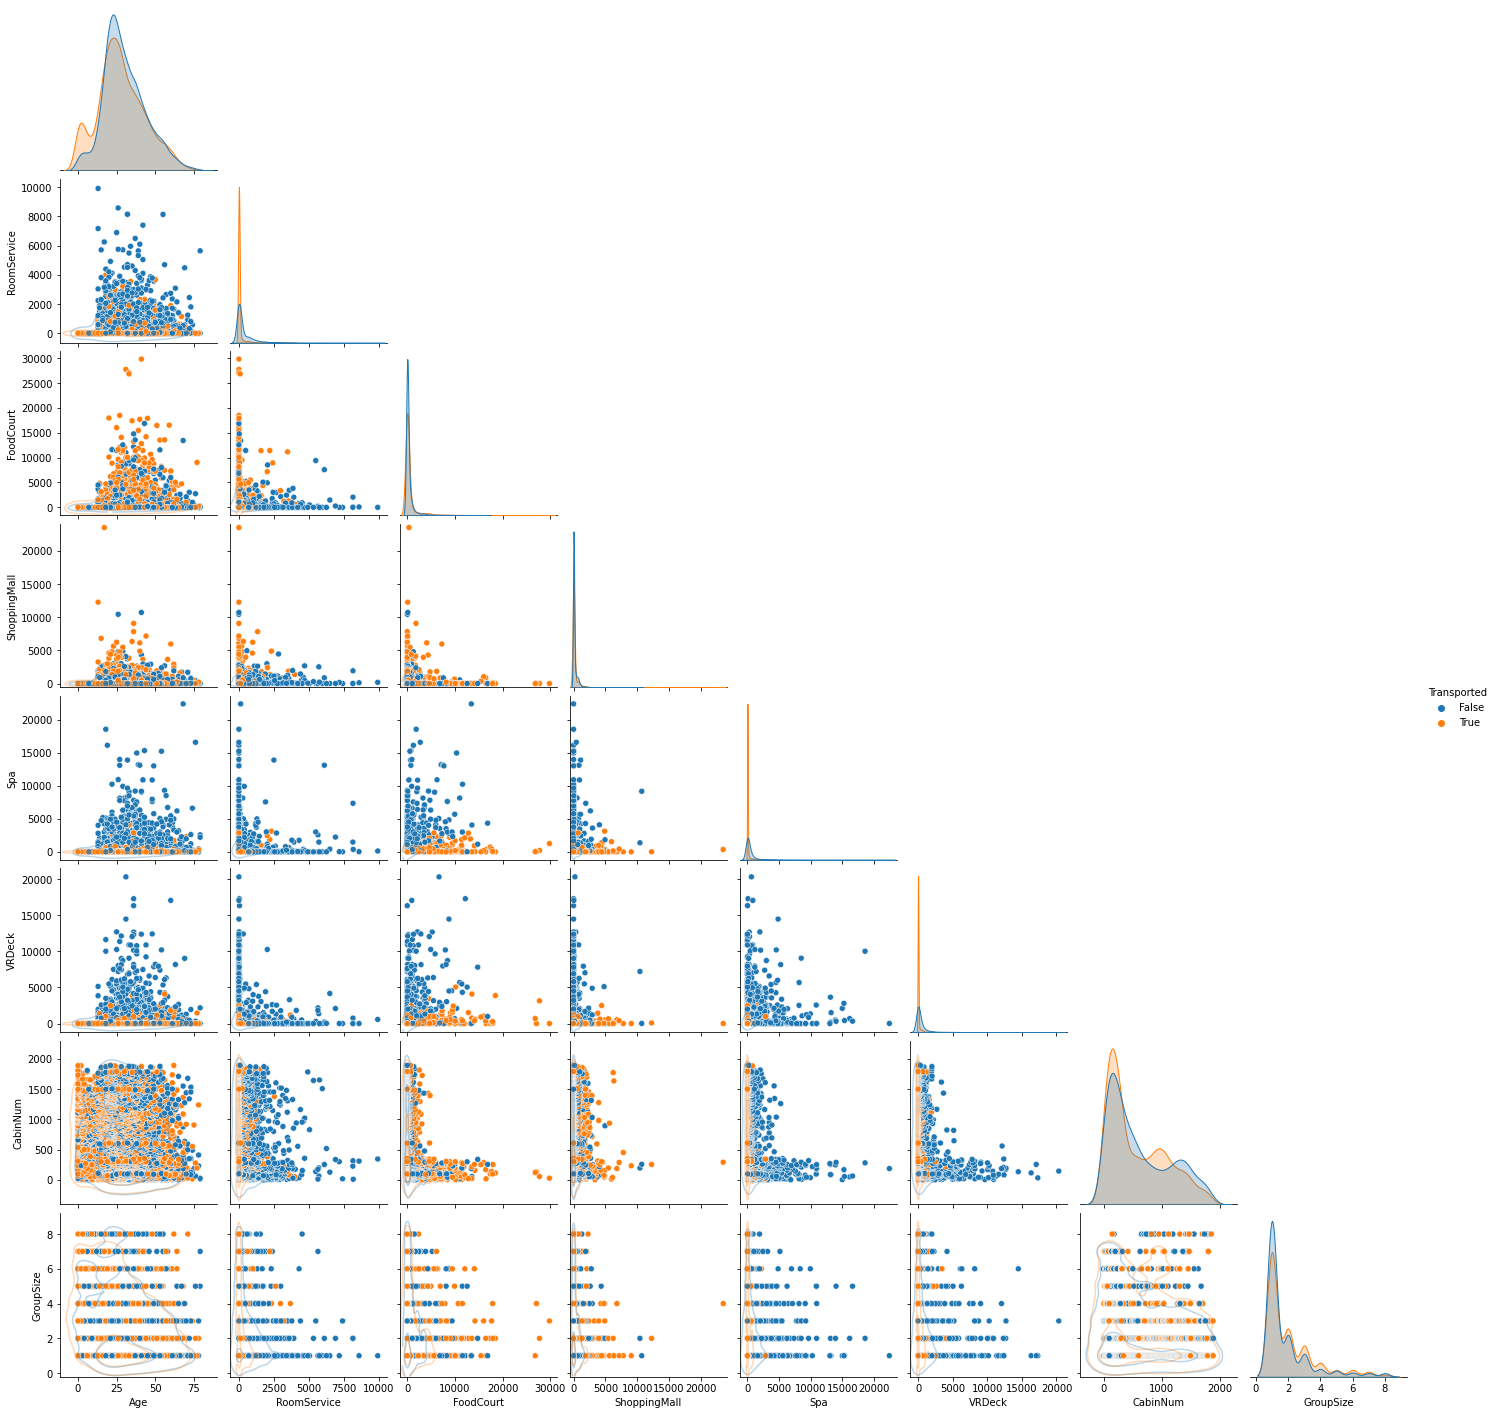

In [14]:
%%time
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'GroupSize']
pairplot_graph = sns.pairplot(train_df[numerical_columns + ['Transported']], corner=True, hue='Transported', diag_kind="kde");
pairplot_graph.map_lower(sns.kdeplot, levels=3, color=".2", alpha=0.3);

CPU times: total: 312 ms
Wall time: 308 ms


<AxesSubplot:>

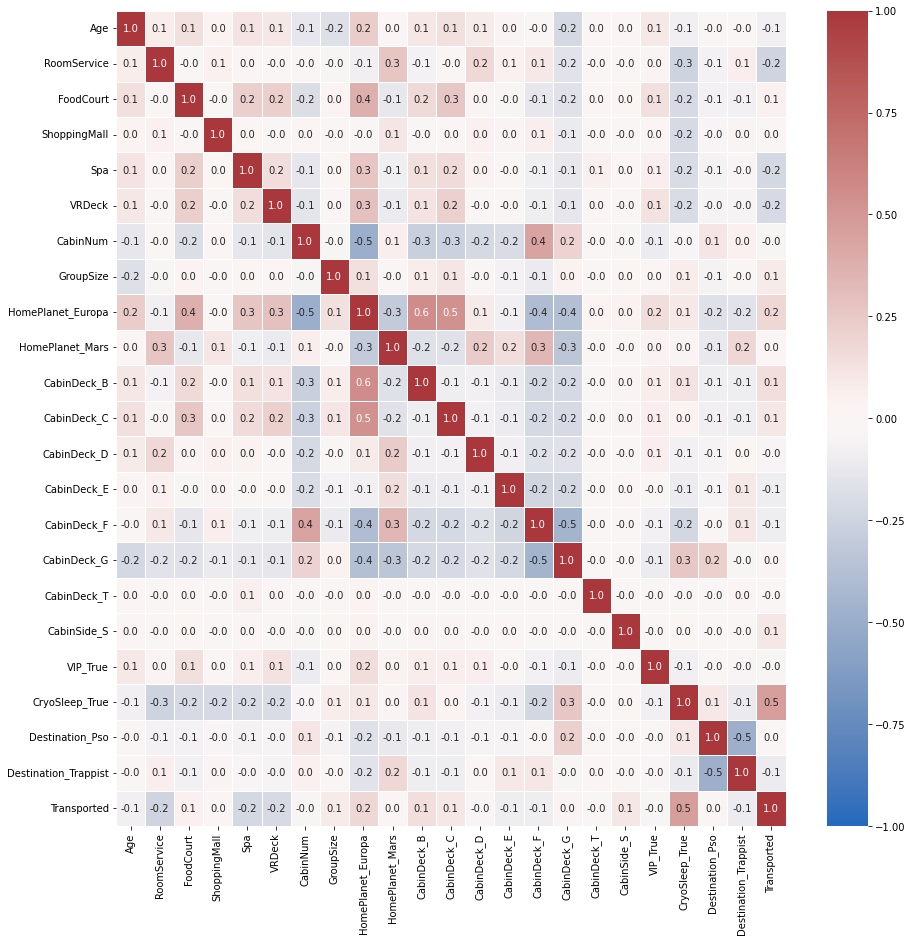

In [15]:
%%time
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train_df.corr(), cmap='vlag', vmin=-1, vmax=1, annot=True, linewidths=.5, fmt='.1f', ax=ax);

## Explore outliers

In [16]:
# # TODO: should be revisited
# outliers_columns = [col for col in list(train_df.columns.values) if col not in ['NameFirst', 'NameLast', 'Transported']]
# outliers_df = pd.DataFrame(columns=train_df.columns)
# for col in outliers_columns:
#     col_outliers_df = train_df[(train_df[col]-train_df[col].mean())/train_df[col].std() > 3.1]
#     outliers_df = pd.concat([outliers_df, col_outliers_df])
# outliers_df

In [17]:
# columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# new_df = train_df[columns]
# new_df[(np.abs(stats.zscore(new_df)) < 3).all(axis=1)]

# Classification

In [18]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV

In [19]:
train_x = train_df.drop(columns=['Transported', 'NameFirst', 'NameLast'])
train_y = train_df.Transported

In [20]:
train_x = (train_x - train_x.mean())/train_x.std()

In [21]:
xgbc_model = XGBClassifier()

In [32]:
xgbc_params = {
'learning_rate': [0.1],   # [0.01, 0.1],
'n_estimators': [100],    # [100],
'max_depth': [3],         # [3, 5, 7],
'gamma': [0],             # [0, 1],
'subsample': [1],         # [0.7, 1],
'colsample_bytree': [0.7] # [0.7, 1]
}

n_folds = 1000

grid =GridSearchCV(xgbc_model, xgbc_params, cv=n_folds, n_jobs=-1, scoring='accuracy');

In [33]:
%%time
grid.fit(train_x,train_y);
grid.best_params_

CPU times: total: 5.55 s
Wall time: 37.3 s


{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1}

In [34]:
grid.best_score_

0.8053571428571429

In [35]:
# current best score: (without John Doe naming)

# grid.best_score_ = 0.8069761904761905

# grid.best_params_ = 
# {'colsample_bytree': 0.7,
#  'gamma': 1,
#  'learning_rate': 0.1,
#  'max_depth': 3,
#  'n_estimators': 100,
#  'subsample': 0.7

## Feature importance

In [36]:
xgbc_model = XGBClassifier(**grid.best_params_)
xgbc_model.fit(train_x,train_y);

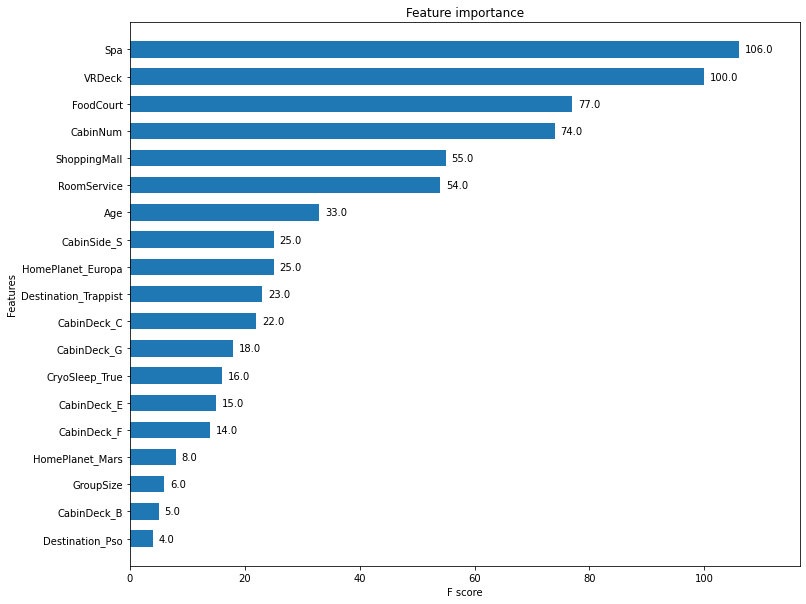

In [37]:
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgbc_model, height=0.6, grid=False, ax=ax);

# Explore NaNs

In [38]:
# df = pd.read_csv('./data/train.csv')

In [39]:
# new_df = df[df.isnull().sum(axis=1) < 2]  # keep all rows with less than 2 nans
# new_df

In [40]:
# df.isna().sum()

In [41]:
# HomePlanet      201  1) uniform distribution; 2) computed distribution; 3) classifier

# CryoSleep       217  1) uniform distribution; 2) computed distribution; 3) classifier

# Cabin           199  -> 
#    CabinDeck    ---  1) uniform distribution; 2) computed distribution; 3) classifier
#    CabinNum     ---  1) mean; 2) normal distribution; 3) computed distribution; 4) regressor
#    CabinSide    ---  1) uniform distribution; 2) computed distribution; 3) classifier

# Destination     182  1) uniform distribution; 2) computed distribution; 3) classifier

# Age             179  1) mean; 2) normal distribution; 3) computed distribution; 4) regressor

# VIP             203  1) uniform distribution; 2) computed distribution; 3) classifier

# RoomService     181  1) mean; 2) normal distribution; 3) computed distribution; 4) regressor

# FoodCourt       183  1) mean; 2) normal distribution; 3) computed distribution; 4) regressor

# ShoppingMall    208  1) mean; 2) normal distribution; 3) computed distribution; 4) regressor

# Spa             183  1) mean; 2) normal distribution; 3) computed distribution; 4) regressor

# VRDeck          188  1) mean; 2) normal distribution; 3) computed distribution; 4) regressor

# Name            200: 1) John Doe (as long as unused)